In [41]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [42]:
data_folder = Path("./titanic")
test_path = data_folder / "test.csv"
train_path = data_folder / "train.csv"

In [43]:
data_original = pd.read_csv(train_path)

In [44]:
data = data_original.copy()

In [45]:
data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C
726,727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30.0,3,0,31027,21.0000,NaN,S
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S


In [46]:
data.drop(columns=["Name", "PassengerId", "Embarked"], inplace=True)

In [47]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
dtype: object

In [48]:
for col in data.select_dtypes(exclude="number"):
    print(f"{col}:\n{data[col].value_counts()}\n")

Sex:
male      577
female    314
Name: Sex, dtype: int64

Ticket:
347082      7
1601        7
CA. 2343    7
CA 2144     6
347088      6
           ..
231945      1
349233      1
330959      1
11752       1
219533      1
Name: Ticket, Length: 681, dtype: int64

Cabin:
B96 B98        4
G6             4
C23 C25 C27    4
F33            3
C22 C26        3
              ..
C86            1
B79            1
C91            1
F G63          1
D10 D12        1
Name: Cabin, Length: 147, dtype: int64



In [49]:
data.drop(columns=["Ticket", "Cabin"], inplace=True)

In [50]:
data["Sex"] = data["Sex"].astype("category")

In [51]:
data.dtypes

Survived       int64
Pclass         int64
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
dtype: object

In [52]:
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

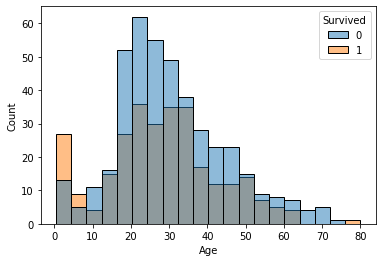

In [53]:
sn.histplot(data=data, x="Age", hue="Survived")

In [54]:
age_imputer = KNNImputer(n_neighbors=5)
age_imputer.fit(data.select_dtypes("number"))

KNNImputer()

In [55]:
data[[c for c in data.select_dtypes("number").columns]] = age_imputer.transform(data.select_dtypes("number"))

<AxesSubplot:xlabel='Age', ylabel='Count'>

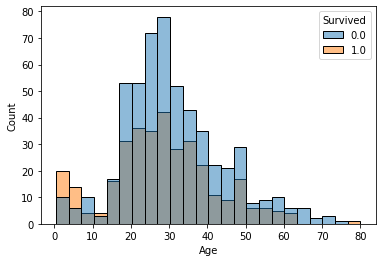

In [56]:
sn.histplot(data=data, x="Age", hue="Survived")

<AxesSubplot:xlabel='Fare', ylabel='Count'>

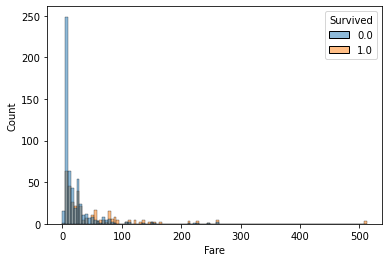

In [57]:
sn.histplot(data=data, x="Fare", hue="Survived")

In [58]:
data["Fare"].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

In [59]:
data["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [60]:
data.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
702,0.0,3.0,female,18.0,0.0,1.0,14.4542
390,1.0,1.0,male,36.0,1.0,2.0,120.0000
33,0.0,2.0,male,66.0,0.0,0.0,10.5000
407,1.0,2.0,male,3.0,1.0,1.0,18.7500
575,0.0,3.0,male,19.0,0.0,0.0,14.5000


Survived
Pclass
Age
SibSp
Parch
Fare


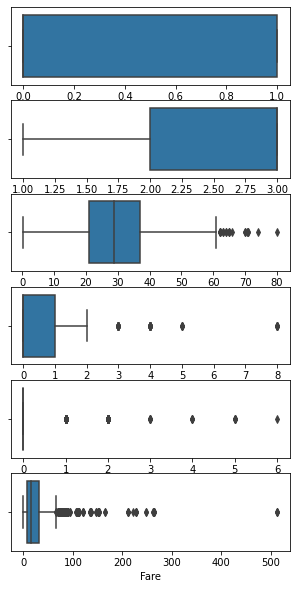

In [61]:
cols = [c for c in data.select_dtypes("number")]

fig, axis = plt.subplots(nrows=len(cols))
fig.set_size_inches(5, 10)

for col, ax in zip(cols, axis):
    print(col)
    sn.boxplot(data=data, x=col, ax=ax)

In [62]:
data["Sex"] = data["Sex"].cat.codes

In [63]:
data = data.reindex(sorted(data.columns), axis=1)

In [64]:
data.describe()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.999930,32.204208,0.381594,2.308642,0.647587,0.523008,0.383838
std,13.619041,49.693429,0.806057,0.836071,0.477990,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.910400,0.000000,2.000000,0.000000,0.000000,0.000000
50%,29.000000,14.454200,0.000000,3.000000,1.000000,0.000000,0.000000
75%,37.000000,31.000000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,3.000000,1.000000,8.000000,1.000000


In [65]:
scalers = {col: MinMaxScaler().fit(np.asarray(data[col]).reshape(-1, 1))
            for col in ["Age", "Fare", "Parch", "SibSp", "Pclass"]}

In [66]:
for col, scaler in scalers.items():
    data[col] = scaler.transform(np.asarray(data[col]).reshape(-1, 1))

In [67]:
data.describe()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.371701,0.062858,0.063599,0.654321,0.647587,0.065376,0.383838
std,0.171136,0.096995,0.134343,0.418036,0.477990,0.137843,0.486592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258608,0.015440,0.000000,0.500000,0.000000,0.000000,0.000000
50%,0.359135,0.028213,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.459663,0.060508,0.000000,1.000000,1.000000,0.125000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Готуємо колонки до кластеризації

In [68]:
x, y = data[data.columns.difference(["Survived"])], data["Survived"]
x, y

(          Age      Fare     Parch  Pclass  Sex  SibSp
 0    0.271174  0.014151  0.000000     1.0    1  0.125
 1    0.472229  0.139136  0.000000     0.0    0  0.125
 2    0.321438  0.015469  0.000000     1.0    0  0.000
 3    0.434531  0.103644  0.000000     0.0    0  0.125
 4    0.434531  0.015713  0.000000     1.0    1  0.000
 ..        ...       ...       ...     ...  ...    ...
 886  0.334004  0.025374  0.000000     0.5    1  0.000
 887  0.233476  0.058556  0.000000     0.0    0  0.000
 888  0.331490  0.045771  0.333333     1.0    0  0.125
 889  0.321438  0.058556  0.000000     0.0    1  0.000
 890  0.396833  0.015127  0.000000     1.0    1  0.000
 
 [891 rows x 6 columns],
 0      0.0
 1      1.0
 2      1.0
 3      1.0
 4      0.0
       ... 
 886    0.0
 887    1.0
 888    0.0
 889    1.0
 890    0.0
 Name: Survived, Length: 891, dtype: float64)

In [90]:
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift
from sklearn.metrics import f1_score

In [84]:
def test_cluster(cluster, x_tr, x_ts, y_tr, y_ts):
    cluster.fit(x_tr)
    print(f"f1: {f1_score(y_ts, cluster.fit_predict(x_ts))}")

In [85]:
xy_train_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)

In [86]:
model = KMeans(n_clusters=2, random_state=15)
test_cluster(model, *xy_train_test)

f1: 0.7086614173228347


In [88]:
model2 = AffinityPropagation(random_state=15)
test_cluster(model2, *xy_train_test)

C:\Users\anton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [92]:
model3 = MeanShift()
test_cluster(model3, *xy_train_test)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [94]:
model3.predict(xy_train_test[0])

array([2, 0, 3, 2, 0, 0, 0, 1, 0, 0, 3, 0, 0, 3, 0, 1, 3, 2, 0, 0, 0, 3,
       1, 0, 0, 3, 0, 1, 0, 0, 1, 2, 0, 3, 1, 0, 1, 3, 0, 2, 1, 0, 1, 3,
       1, 1, 3, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 3, 0, 3, 0,
       0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 0, 3, 0, 1, 1,
       0, 2, 0, 1, 0, 0, 0, 0, 3, 2, 0, 1, 0, 1, 0, 3, 2, 0, 0, 3, 1, 1,
       1, 3, 0, 2, 1, 3, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 1, 3, 0, 1,
       2, 0, 0, 0, 1, 3, 3, 3, 2, 1, 0, 1, 0, 0, 0, 1, 1, 3, 0, 0, 0, 2,
       3, 3, 1, 0, 3, 2, 0, 2, 3, 0, 0, 2, 0, 3, 0, 0, 2, 1, 1, 2, 0, 0,
       2, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 3, 2, 0, 1, 0, 3, 1,
       1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 3, 1, 3, 2, 1, 0, 0, 0, 3, 0, 2, 3,
       2, 3, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 3, 1, 0, 1, 2, 0, 1, 2,
       3, 3, 1, 2, 0, 0, 2, 2, 2, 2, 2, 3, 1, 0, 0, 0, 1, 0, 1, 3, 1, 2,
       3, 3, 0, 0, 1, 0, 3, 1, 3, 2, 2, 1, 2, 0, 3, 3, 3, 3, 3, 1, 2, 3,
       2, 0, 2, 1, 2, 2, 0, 3, 1, 0, 1, 1, 1, 0, 0,

In [72]:
# depends on fitted "age_imputer" and feature scalers
def prepare_data(x_start):
    x = x_start.copy()
    
    x.drop(columns=["Name", "PassengerId", "Embarked", "Ticket", "Cabin"], inplace=True)
    
    if "Survived" in x.columns:
        x.drop(columns=["Survived"], inplace=True)
    
    x["Sex"] = x["Sex"].astype("category").cat.codes
    
    x[[c for c in x.select_dtypes("number").columns]] = age_imputer.transform(x.select_dtypes("number"))
    
    for col, scaler in scalers.items():
        x[col] = scaler.transform(np.asarray(x[col]).reshape(-1, 1))

    x = x.reindex(sorted(x.columns), axis=1)
    return x

In [73]:
data_test = pd.read_csv(test_path)
data_eval = prepare_data(data_test)
data_eval.sample()

,Age,Fare,Parch,Pclass,Sex,SibSp
378,0.685851,0.097594,0.0,0.0,1.0,0.0


In [74]:
result = pd.DataFrame(index=data_test["PassengerId"])
result["Survived"] = model.predict(data_eval)
result.to_csv("results.csv")
result

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
